# This notebook will be used to read in the two .nc files containing the Sentinel-1 Gamma0 backscatter, as well as the composite bands created from the backscatter. Using these .nc files, cloud-masked Sentinel-2 images will be retrieved from the GEE. The NDVI and NDWI will be used at 10-meter resolution. Otsu thresholding will be applied on all 9 bands, where the NDVI and NDWI will serve as refinement given the finer spatial resolution

In [17]:
import netCDF4 as nc
from netCDF4 import Dataset
import os
from osgeo import gdal
import rasterio
import ee
import geemap
import geemap.colormaps as cm
import numpy as np
from pyproj import Transformer
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt
from osgeo import gdal

In [39]:
# Function to visualize the NetCDF bands
def visualize_nc_file(nc_file):
    # Open the NetCDF file
    dataset = nc.Dataset(nc_file, mode='r')

    # Extract variables
    lat = dataset.variables['lat'][:]
    lon = dataset.variables['lon'][:]
    gamma0_vv = dataset.variables['Gamma0_VV'][:]
    gamma0_vh = dataset.variables['Gamma0_VH'][:]

    # Close the dataset after reading
    dataset.close()

    # Determine global min/max for consistent color scaling
    vmin = min(gamma0_vv.min(), gamma0_vh.min())
    vmax = max(gamma0_vv.max(), gamma0_vh.max())

    # Plot Gamma0_VV
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    im1 = plt.imshow(gamma0_vv, extent=[lon.min(), lon.max(), lat.min(), lat.max()],
                     cmap='gray', interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.colorbar(im1, label='Gamma0_VV')
    plt.title('Gamma0_VV')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Plot Gamma0_VH
    plt.subplot(1, 2, 2)
    im2 = plt.imshow(gamma0_vh, extent=[lon.min(), lon.max(), lat.min(), lat.max()],
                     cmap='gray', interpolation='nearest', vmin=vmin, vmax=vmax)
    plt.colorbar(im2, label='Gamma0_VH')
    plt.title('Gamma0_VH')
    plt.xlabel('Longitude')

    plt.tight_layout()
    plt.show()

def check_spatial_resolution(nc_file):
    # Open the NetCDF file
    dataset = nc.Dataset(nc_file, mode='r')

    # Extract latitude and longitude
    lat = dataset.variables['lat'][:]
    lon = dataset.variables['lon'][:]

    # Close the dataset
    dataset.close()

    # Calculate the resolution by taking the mean difference
    lat_res = np.abs(lat[1] - lat[0])  # Latitude resolution
    lon_res = np.abs(lon[1] - lon[0])  # Longitude resolution

    print(f"Latitude resolution: {lat_res:.6f} degrees")
    print(f"Longitude resolution: {lon_res:.6f} degrees")

    # Approximate resolution in meters (assuming 1 degree ≈ 111 km)
    lat_res_m = lat_res * 111000
    lon_res_m = lon_res * 111000 * np.cos(np.deg2rad(lat.mean()))

    print(f"Approximate pixel size: {lat_res_m:.2f} meters (latitude), {lon_res_m:.2f} meters (longitude)")

def export_to_raster_rasterio(nc_file, output_tif):
    # Open the NetCDF file
    dataset = nc.Dataset(nc_file, mode='r')

    # Extract the variables
    gamma0_vv = dataset.variables['Gamma0_VV'][:]
    gamma0_vh = dataset.variables['Gamma0_VH'][:]
    lat = dataset.variables['lat'][:]
    lon = dataset.variables['lon'][:]

    # Close the NetCDF file
    dataset.close()

    # Define raster metadata
    transform = rasterio.transform.from_bounds(lon.min(), lat.min(), lon.max(), lat.max(),
                                               gamma0_vv.shape[1], gamma0_vv.shape[0])

    # Define raster profile (metadata)
    profile = {
        'driver': 'GTiff',
        'dtype': 'float32',
        'nodata': None,
        'count': 2,  # Two bands
        'height': gamma0_vv.shape[0],
        'width': gamma0_vv.shape[1],
        'crs': 'EPSG:4326',  # Assuming lat/lon WGS84
        'transform': transform
    }

    # Save data to GeoTIFF
    with rasterio.open(output_tif, 'w', **profile) as dst:
        dst.write(gamma0_vv.astype(np.float32), 1)  # First band
        dst.write(gamma0_vh.astype(np.float32), 2)  # Second band

    print(f"Raster saved as {output_tif}")

In [30]:
project = 'SabineRS'
file_dir = f'/home/clay/Documents/{project}/Sentinel-1/GRD/ASCENDING/136/93/10_netcdfs'
grd_files = sorted([os.path.join(file_dir, f'{file}') for file in os.listdir(file_dir) if file.endswith('.nc')]) # need to test NetCDF export

In [31]:
data = Dataset(grd_files[-1])
nc_vars = data.variables

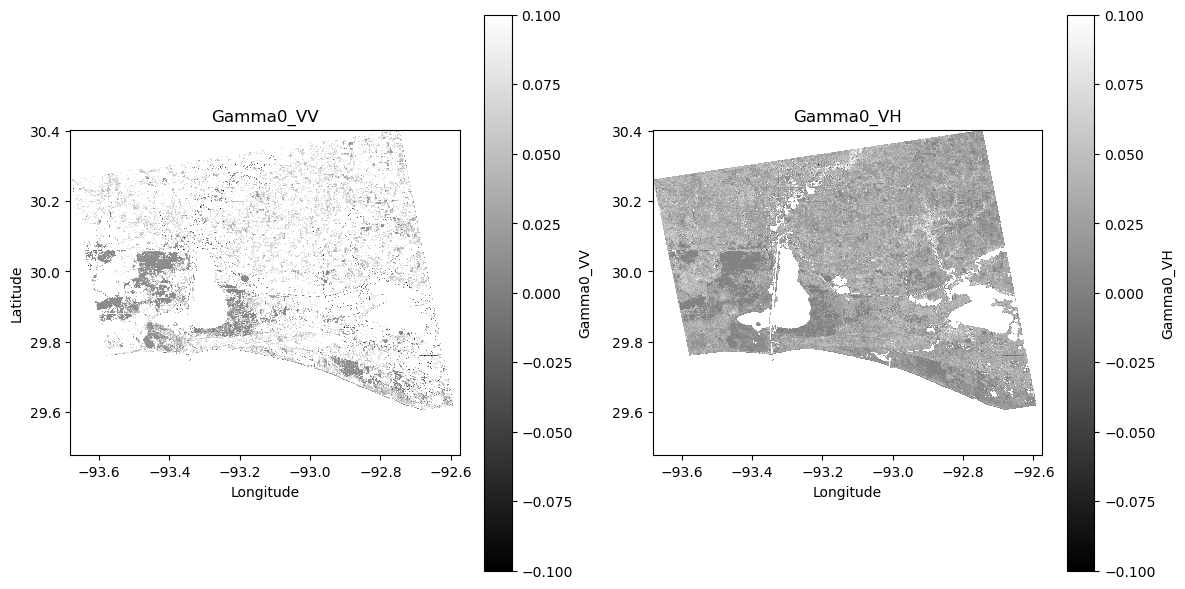

Latitude resolution: 0.000180 degrees
Longitude resolution: 0.000180 degrees
Approximate pixel size: 19.94 meters (latitude), 17.28 meters (longitude)


In [41]:
visualize_nc_file(grd_files[0])
check_spatial_resolution(grd_files[0])

In [48]:
def add_composite_bands_to_nc(nc_file):
    # Open the NetCDF file in append mode
    dataset = nc.Dataset(nc_file, mode='r+')

    # Extract the Gamma0 backscatter values
    vv = dataset.variables['Gamma0_VV'][:].astype(np.float32)
    vh = dataset.variables['Gamma0_VH'][:].astype(np.float32)

    # Normalize the backscatter data using min-max normalization
    def normalize(data):
        min_val = np.nanmin(data)
        max_val = np.nanmax(data)
        return (data - min_val) / (max_val - min_val + 1e-8)  # Avoid division by zero

    vv_norm = normalize(vv)
    vh_norm = normalize(vh)

    # Compute indices using normalized values

    # VH/VV Ratio (VH_VV)
    vh_vv = vh_norm / (vv_norm + 1e-8)

    # Normalized Difference Polarization Index (NDPI)
    ndpi = (vv_norm - vh_norm) / (vv_norm + vh_norm + 1e-8)

    # Normalized VH Index (NVHI)
    nvhi = vh_norm / (vh_norm + vv_norm + 1e-8)

    # Normalized VV Index (NVVI)
    nvvi = vv_norm / (vv_norm + vh_norm + 1e-8)

    # Radar Vegetation Index (RVI)
    rvi = (4 * vh_norm) / (vh_norm + vv_norm + 1e-8)

    # Define new variables for computed indices in the NetCDF file
    indices = {
        "VH_VV": vh_vv,
        "NDPI": ndpi,
        "NVHI": nvhi,
        "NVVI": nvvi,
        "RVI": rvi
    }

    for index_name, index_data in indices.items():
        if index_name not in dataset.variables:
            var = dataset.createVariable(index_name, np.float32, ('lat', 'lon'), fill_value=np.nan)
            var[:] = index_data
            var.units = "unitless"
            var.description = f"{index_name} computed index"
            print(f"Added {index_name} to NetCDF file")

    # Close the dataset
    dataset.close()

    print(f"Composite bands successfully added to {nc_file}")

In [49]:
nc_file = grd_files[0]

compute_sar_indices_with_normalization(nc_file, nc_file.replace('nc', 'tif'))

Composite raster with original and computed bands saved as /home/clay/Documents/SabineRS/Sentinel-1/GRD/ASCENDING/136/93/tifs/20191001.tif


Total bands in the raster: 7


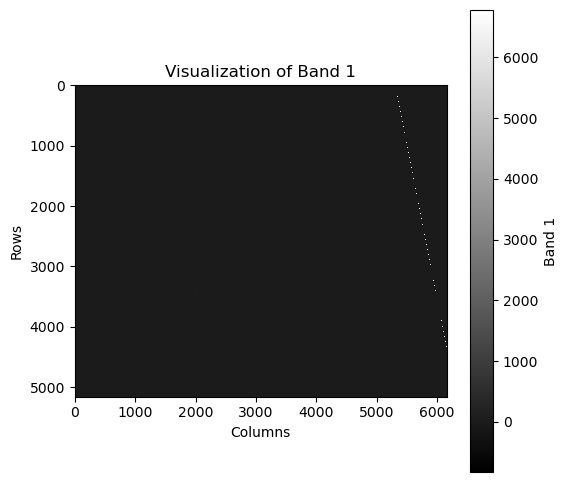

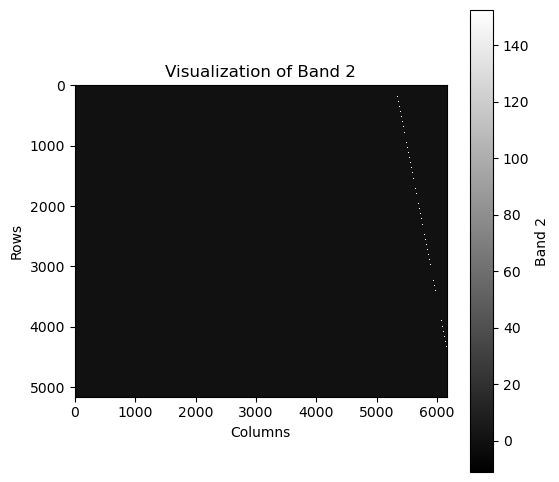

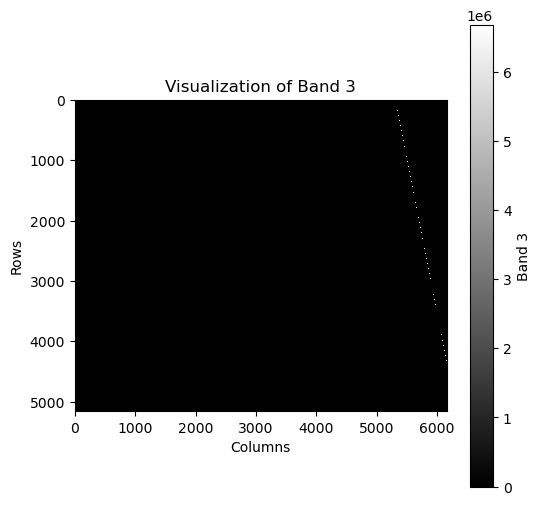

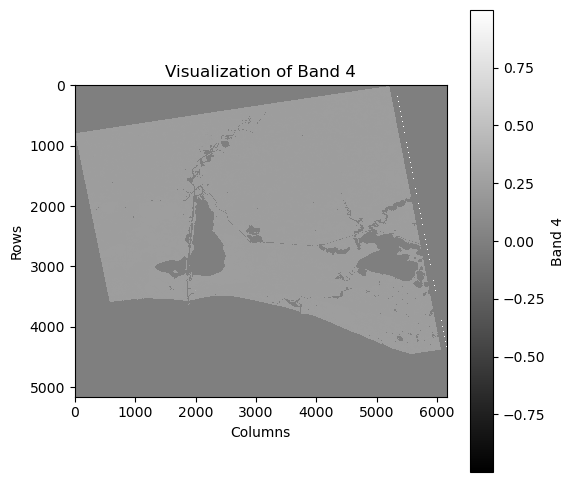

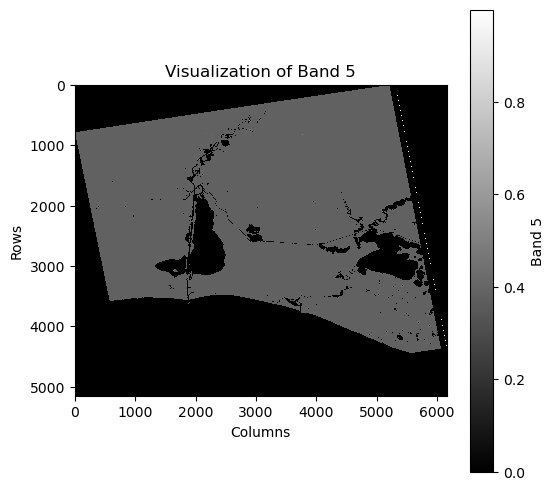

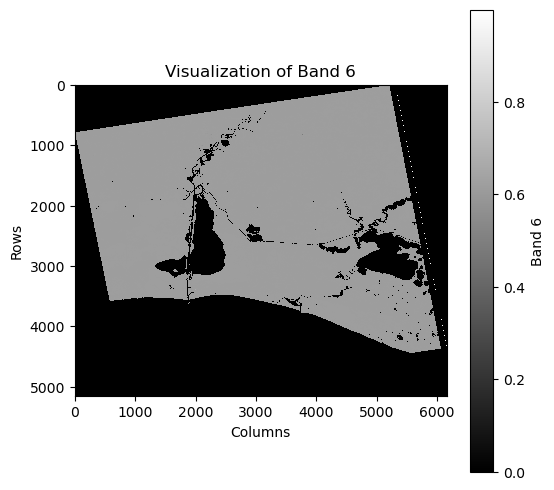

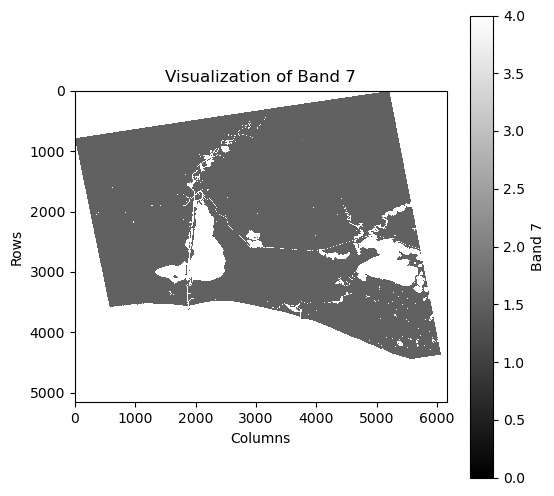


Raster Metadata:
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 6162, 'height': 5159, 'count': 7, 'crs': CRS.from_wkt('GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]'), 'transform': Affine(0.00017963390020968341, 0.0, -93.68183131860044,
       0.0, -0.00017962823165297513, 30.403070192729114), 'blockxsize': 6162, 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}


In [50]:
def check_and_visualize_bands(tif_file):
    # Open the GeoTIFF file
    with rasterio.open(tif_file) as src:
        num_bands = src.count  # Get the number of bands
        print(f"Total bands in the raster: {num_bands}")

        # Loop through each band and visualize it
        for band_id in range(1, num_bands + 1):
            band = src.read(band_id)  # Read the band

            # Handle nodata values and replace them with NaN for visualization
            band = np.where(band == src.nodata, np.nan, band)

            plt.figure(figsize=(6, 6))
            plt.imshow(band, cmap='gray', interpolation='nearest')
            plt.colorbar(label=f'Band {band_id}')
            plt.title(f'Visualization of Band {band_id}')
            plt.xlabel('Columns')
            plt.ylabel('Rows')
            plt.show()

        # Check metadata of the raster
        print("\nRaster Metadata:")
        print(src.profile)

check_and_visualize_bands(nc_file.replace('nc', 'tif'))

# Functions

In [ ]:
def get_s1(aoi, start_date, end_date, orbit):
    ## Sentinel-1 ImageCollection
    s1 = (ee.ImageCollection('COPERNICUS/S1_GRD')
               .filterBounds(aoi)
               .filterDate(ee.Date(start_date), ee.Date(end_date))
               .map(lambda img: img.set('date', ee.Date(img.date()).format('YYYYMMdd')))
               .filter(ee.Filter.eq('orbitProperties_pass', orbit))
               .select(['VV', 'VH'])
               .sort('date')
    )

    s1 = s1.map(lambda img: img.clip(aoi))

    return s1
def get_s2_sr_cld_col(aoi, start_date, end_date, cloud_filter):
    # Import and filter S2 SR.
    s2_sr_col = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(aoi)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', cloud_filter)))

    # Import and filter s2cloudless.
    s2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        .filterDate(start_date, end_date))

    # Join the filtered s2cloudless collection to the SR collection by the 'system:index' property.
    combined_coll = ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': s2_sr_col,
        'secondary': s2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))

    return combined_coll.map(lambda img: img.clip(aoi))

def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))

def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img.addBands(is_cld_shdw)

def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select('B.*').updateMask(not_cld_shdw)

def export_image_to_drive(image, description, aoi):
    """
    Export a single image to Google Drive.

    Args:
        image: ee.Image, the image to be exported.
        description: str, unique description for the export task.
        aoi: ee.Geometry, the area of interest for the export.
    """

    image = image.select(['B2', 'B3', 'B4', 'B8'])
    # Setup the export task
    task = ee.batch.Export.image.toDrive(
        image=image,
        description=description,
        region=aoi,  # Make sure the geometry (aoi) is defined earlier
        fileFormat='GeoTIFF',
        scale=10  # Adjust the scale as needed
    )
    task.start()
    print(f'Exporting {description} to Drive...')

In [ ]:
def s2_10m_target_indices(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')

    return image.addBands([ndvi, ndwi])

def s1_target_indices(image):
    vh_vv = image.expression(
        'VH / VV',
        {
            'VV': image.select('VV'),
            'VH': image.select('VH')
        }
    ).rename('VH_VV')

    ndpi = image.expression(
        '(VV - VH) / (VV + VH)',
        {
            'VV': image.select('VV'),
            'VH': image.select('VH')
        }
    ).rename('NDPI')

    nvhi = image.expression(
        'VH / (VH + VV)',
        {
            'VV': image.select('VV'),
            'VH': image.select('VH')
        }
    ).rename('NVHI')

    nvvi = image.expression(
        'VV / (VV + VH)',
        {
            'VV': image.select('VV'),
            'VH': image.select('VH')
        }
    ).rename('NVVI')

    rvi = image.expression(
        '(4 * VH) / (VH + VV)',
        {
            'VV': image.select('VV'),
            'VH': image.select('VH')
        }
    ).rename('RVI')

    return image.addBands([vh_vv, ndpi, nvhi, nvvi, rvi])


def extract_valid_bounds_to_epsg4326(raster_path):
    """Extracts the bounding box of valid (non-NaN) data from a raster and converts it to EPSG:4326."""
    with rasterio.open(raster_path) as src:
        # Read the raster data
        data = src.read(1)  # Assuming a single band
        transform = src.transform  # Affine transform of the raster
        src_crs = src.crs  # Source CRS of the raster

        # Create a mask for valid (non-NaN) pixels
        valid_mask = ~np.isnan(data)

        # Find the row and column indices of valid pixels
        valid_rows, valid_cols = np.where(valid_mask)

        if valid_rows.size == 0 or valid_cols.size == 0:
            raise ValueError("No valid data in the raster.")

        # Calculate the geographic coordinates of the valid bounds
        min_row, max_row = valid_rows.min(), valid_rows.max()
        min_col, max_col = valid_cols.min(), valid_cols.max()

        # Use the transform to convert row/col to geographic bounds
        min_x, min_y = rasterio.transform.xy(transform, min_row, min_col, offset="ul")
        max_x, max_y = rasterio.transform.xy(transform, max_row, max_col, offset="ul")

        # Bounds in the source CRS
        bounds_src_crs = (min_x, min_y, max_x, max_y)

        # Transform bounds to EPSG:4326
        transformer = Transformer.from_crs(src_crs, "EPSG:4326", always_xy=True)
        min_x_4326, min_y_4326 = transformer.transform(min_x, min_y)
        max_x_4326, max_y_4326 = transformer.transform(max_x, max_y)

        bounds_epsg4326 = (min_x_4326, min_y_4326, max_x_4326, max_y_4326)
        bbox = ee.Geometry.BBox(bounds_epsg4326[0], bounds_epsg4326[1], bounds_epsg4326[2], bounds_epsg4326[3])

    return bbox

def get_date(image):
    return ee.Feature(None, {'date': image.date().format('YYYY-MM-dd')})

def mosaic_images_for_date(date, sentinel1_col, sentinel2_col):
    date_filter = ee.Filter.date(date, ee.Date(date).advance(1, 'day'))
    
    # Try to get Sentinel-1 mosaic; return None if no images available
    s1_filtered = sentinel1_col.filter(date_filter)
    s1_mosaic = ee.Algorithms.If(s1_filtered.size().gt(0), s1_filtered.mosaic(), None)
    
    # Try to get Sentinel-2 mosaic; return None if no images available
    s2_filtered = sentinel2_col.filter(date_filter)
    s2_mosaic = ee.Algorithms.If(s2_filtered.size().gt(0), s2_filtered.mosaic(), None)
    
    return ee.Dictionary({
        'date': date,
        'S1': s1_mosaic,
        'S2': s2_mosaic
    })

## Function to add RGB images to the map.
def add_rgb_to_map(image, map_object, coll):

    date = ee.Date(image.get('date')).format('YYYY-MM-dd').getInfo()
    for band in coll.first().bandNames().getInfo(): ## all images if small enough image collection
        map_object.addLayer(image, {'min': 0, 'max': 2000, 'bands': ['B4', 'B3', 'B2']}, f'{date}_rgb')

## Function to add spectral indices images to the map.
def add_ind_to_map(image, map_object, band):

    date = ee.Date(image.get('date')).format('YYYY-MM-dd').getInfo()
    if band =='NDWI':
        map_object.addLayer(image, {'min': -1, 'max': 1, 'bands': band, 'palette': cm.palettes.ndvi}, f'{date}_{band}')
    elif band =='NDVI': 
        map_object.addLayer(image, {'min': -1, 'max': 1, 'bands': band, 'palette': cm.palettes.ndwi}, f'{date}_{band}')

## Function to add spectral indices images to the map.
def add_sar_to_map(image, map_object, target_band):

    date = ee.Date(image.get('date')).format('YYYY-MM-dd').getInfo()
    map_object.addLayer(image, {'min': -50, 'max': 1, 'bands': target_band}, f'{date}_{target_band}')

# 1. Read in baseline wrapped interferogram to extract bbox for GEE image search

In [ ]:
work_dir = '/home/clay/Documents/SabineRS/Sentinel-1/InSAR'

In [ ]:
insar_dir = os.path.join(work_dir, 'interferometry')
geo_im = [os.path.join(insar_dir, f'work/merged/{file}') for file in os.listdir(os.path.join(insar_dir, f'work/merged')) if '.geo.vrt' in file][0]
aoi = extract_valid_bounds_to_epsg4326(geo_im)

# Retrieve Sentinel imagery from GEE

In [ ]:
s2_cloud_cov = 20
START_DATE = '2019-10-01'
END_DATE = '2024-10-01'
CLD_PRB_THRESH = 40
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 2
BUFFER = 100
ORBIT = 'ASCENDING'

s2_coll = get_s2_sr_cld_col(aoi, START_DATE, END_DATE, s2_cloud_cov)
s2_cm = (s2_coll.map(add_cld_shdw_mask).map(apply_cld_shdw_mask).map(s2_10m_target_indices)).select(['NDVI', 'NDWI'])       # cloud masked sentinel-2 10-meter ndvi and ndwi bands

s1 = get_s1(aoi, START_DATE, END_DATE, ORBIT)                           # 10-meter GRD
s1_all = (s1.map(s1_target_indices))                            # should be the 7 bands needed

# Mosaic images with matching dates
- Common cells for GEE Sentinel imagery typically smaller than that of ASF/Copernicus
- Could result in multiple images for a single day
- Iterate through the information or each of the images in the S1 and S2 collections, mosaic matching dates.

In [ ]:
s2_date_list = s2_cm.map(get_date).aggregate_array('date').getInfo()
s1_date_list = s1_all.map(get_date).aggregate_array('date').getInfo()
all_dates = sorted(list(set(s1_date_list + s2_date_list)))

In [ ]:
# Create a dictionary of mosaicked images for all dates
mosaic_dict = {}

for date in all_dates:
    mosaics = mosaic_images_for_date(date, s1_all, s2_cm)
    mosaic_dict[date] = mosaics

# Temporally register images together for more accurate voting
- Different relook frequencies lead to epochs on different dates. Need to match up the dates as close as possible

In [ ]:
# Filter out entries with valid S1 data within GEE without pulling to client-side
valid_s1_data = {date: mosaics for date, mosaics in mosaic_dict.items() if mosaics.get('S1').getInfo()}
valid_date_list = [key for key in valid_s1_data.keys()]

# Use this to visualize the Mosaics

In [ ]:
Map = geemap.Map()
Map.centerObject(aoi, 12)

for date in valid_date_list[:10]:
    
    sar_im = ee.Image(valid_s1_data[date].get('S1'))

    # add_ind_to_map(rgb_im, Map, 'NDWI')
    add_sar_to_map(sar_im, Map, 'VV', date)

Map.addLayerControl(position = 'topright')
Map

In [ ]:
im = valid_s1_data[date].get('S1')
display(im.evaluate())

In [ ]:
im_bounds = []

for date in valid_s1_data.keys():
    im = ee.Image(valid_s1_data[date].get('S1'))
    im_bounds.append(im.geometry().getInfo()['coordinates'])

im_bounds

# Otsu threshold
- Need to upsample the GRD images to ~20-meter resolution to match with interferograms
- Otsu on all 20-meter SAR bands
- Otsu on NDVI and NDWI 10-meter bands
- Majority voting with SAR, refinement with NDVI and NDWI
- Final shoul give water mask for each registered pair